In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    fowlkes_mallows_score,
    normalized_mutual_info_score
)


#Các hàm xử lí

##TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [ ]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

In [ ]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

##PCA

In [ ]:
def pca(X, n_components_pca=50, use_pca = True):
    if use_pca:
      pca = PCA(n_components=n_components_pca)
      X_pca = pca.fit_transform(X)
      return X_pca

    return X

##Model

In [ ]:
def evaluate_clustering(X, labels, y_true=None):
    results = {
        "SIL": silhouette_score(X, labels),
        "DBI": davies_bouldin_score(X, labels),
        "CH": calinski_harabasz_score(X, labels)
    }

    if y_true is not None:
        results.update({
            "ARI": adjusted_rand_score(y_true, labels),
            "FMI": fowlkes_mallows_score(y_true, labels),
            "NMI": normalized_mutual_info_score(y_true, labels)
        })
    else:
        results.update({
            "ARI": None,
            "FMI": None,
            "NMI": None
        })

    return results


###KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def kmeans(df, X_pca, n_clusters_range=range(2, 11), random_state=42, max_iter=3000):
  metrics = []
  labels = []
  kmeanses = []

  for k in n_clusters_range:
      kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=max_iter)
      kmeanses.append(kmeans)

      label = kmeans.fit_predict(X_pca)
      labels.append(label)

      metric = evaluate_clustering(
          X_pca,
          label,
          df["Emotion"]
      )
      metric["K"] = k
      metrics.append(metric)

  return metrics, labels

#Pipeline

In [ ]:
def pipeline_kmeans(df, n_clusters_range=range(2, 11), random_state=42, max_iter=300,
                    min_df=2, max_df=0.95, max_features=8000,
                    n_components_pca=0.9, use_pca = True, k = 2):

  tfidf_matrix, tfidf_vectorizer = tfidf_embedding(df['Tokenized_Sentence'], max_features=max_features, min_df=2, max_df=0.95)
  X_tfidf = tfidf_transform(df['Tokenized_Sentence'], tfidf_vectorizer)
  X_tfidf = convert_to_array(X_tfidf)

  X_pca = pca(X_tfidf, n_components_pca = n_components_pca, use_pca = True)
  metrics, labels = kmeans(df, X_pca, n_clusters_range=n_clusters_range, random_state=42, max_iter=max_iter)
  return X_pca, metrics, labels



##Trực quan

###Metrics

In [ ]:
def plot_metrics(results):
  df_results = pd.DataFrame(results)
  df_results = df_results[
      ["K", "SIL", "DBI", "CH", "ARI", "FMI", "NMI"]
  ]

  print(df_results)

  metrics = ["SIL", "DBI", "CH", "ARI", "FMI", "NMI"]
  for metric in metrics:
    plt.figure()
    plt.plot(df_results["K"], df_results[metric], marker='o')
    plt.ylabel(f"{metric}")
    plt.show()



###K cụm

In [ ]:
def plot_clusters(X_pca, labels, k):
  df_labels = pd.DataFrame(labels)
  df_labels = df_labels.T
  df_labels.columns = [i for i in range(2, 11)]

  pca_2d = PCA(n_components=2)
  X_pca_2d = pca_2d.fit_transform(X_pca)

  plt.figure(figsize=(7, 5))
  scatter = plt.scatter(
      X_pca_2d[:, 0],
      X_pca_2d[:, 1],
      c=df_labels[k],
      cmap="rainbow",
      alpha=0.7
  )

  plt.xlabel("PCA-1")
  plt.ylabel("PCA-2")
  plt.title(f"Emotion Clusters Visualization (K = {k})")
  plt.colorbar(scatter, label="Cluster ID")
  plt.tight_layout()
  plt.show()

#Chạy pipeline

In [ ]:
data = pd.read_csv('merged_data.csv', encoding="utf-8-sig")

In [ ]:
import ast

# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
data['Tokenized_Sentence'] = data['Tokenized_Sentence'].apply(ast.literal_eval)

In [ ]:
data_tfidf_pca, metrics, labels = pipeline_kmeans(data, n_clusters_range=range(2, 11), random_state=42, max_iter=3000, use_pca=True, n_components_pca=20)

TF-IDF hoàn thành!
Shape: (8420, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 111360


    K       SIL       DBI          CH       ARI       FMI       NMI
0   2  0.144932  3.107948  478.538641 -0.003444  0.342840  0.009504
1   3  0.086982  3.088474  366.058914  0.005009  0.310832  0.008678
2   4  0.103395  2.639584  401.221733  0.004527  0.291743  0.016463
3   5  0.113488  2.359393  410.567227  0.001050  0.269056  0.023938
4   6  0.119978  2.383063  392.870479  0.000495  0.237278  0.025243
5   7  0.130645  2.200884  419.691872  0.002696  0.220870  0.026962
6   8  0.152402  1.887627  446.854819  0.001299  0.254479  0.023867
7   9  0.152057  1.895233  403.703556  0.000841  0.250959  0.026108
8  10  0.136539  1.815390  418.826438 -0.000945  0.224048  0.026352


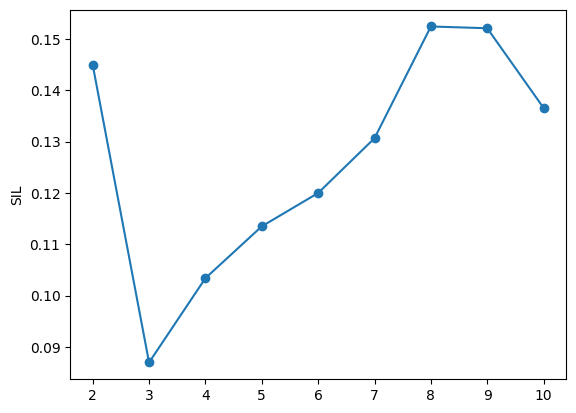

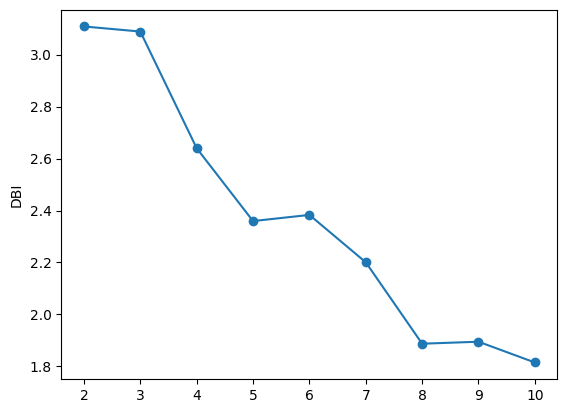

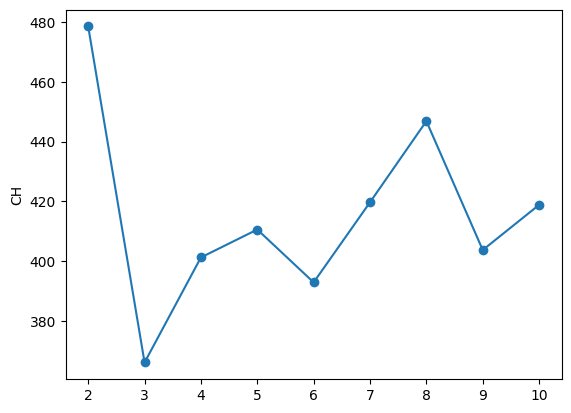

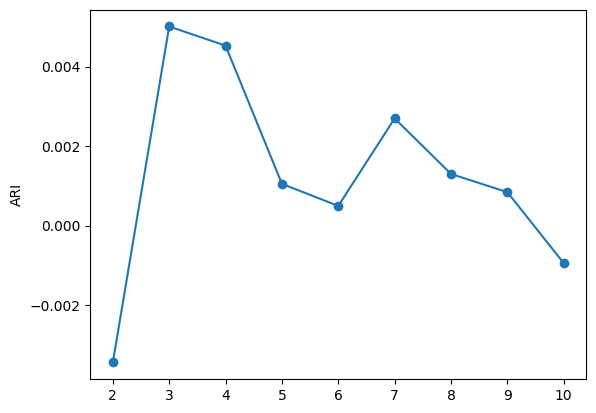

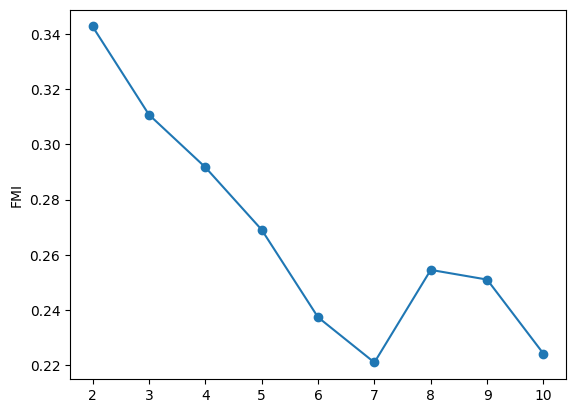

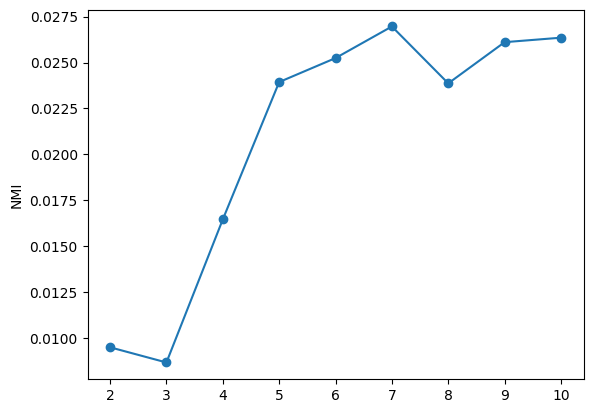

In [ ]:
plot_metrics( metrics)

In [ ]:
def plot_clusters_pca(X_pca, labels, k):
  df_labels = pd.DataFrame(labels)
  df_labels = df_labels.T
  df_labels.columns = [i for i in range(2, 11)]


  plt.figure(figsize=(7, 5))
  scatter = plt.scatter(
      X_pca[:, 0],
      X_pca[:, 1],
      c=df_labels[k],
      cmap="rainbow",
      alpha=0.7
  )

  plt.xlabel("PCA-1")
  plt.ylabel("PCA-2")
  plt.title(f"Emotion Clusters Visualization (K = {k})")
  plt.colorbar(scatter, label="Cluster ID")
  plt.tight_layout()
  plt.show()

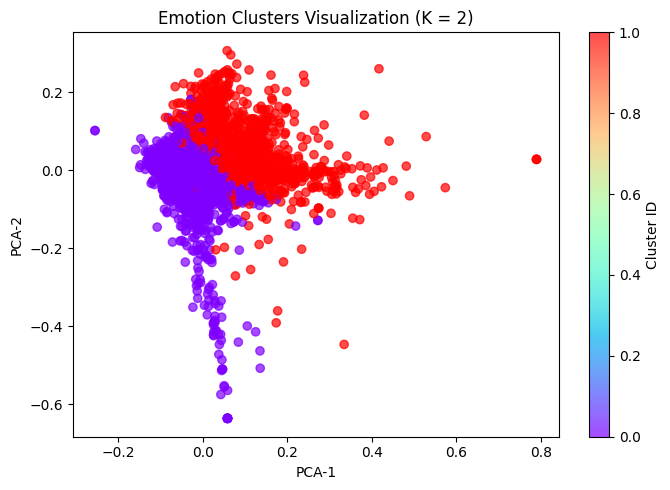

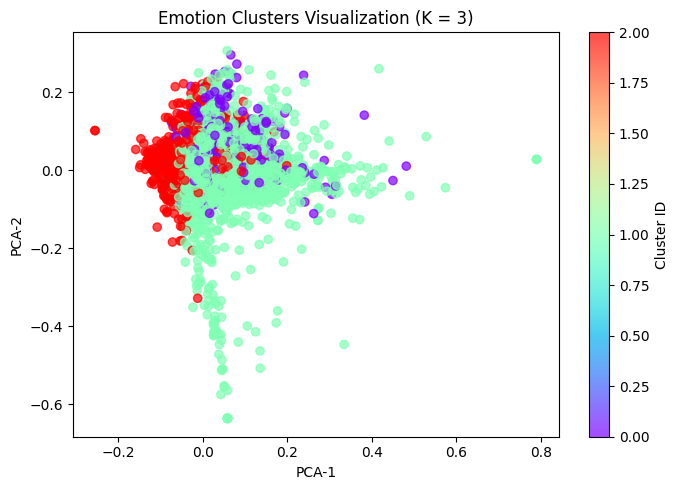

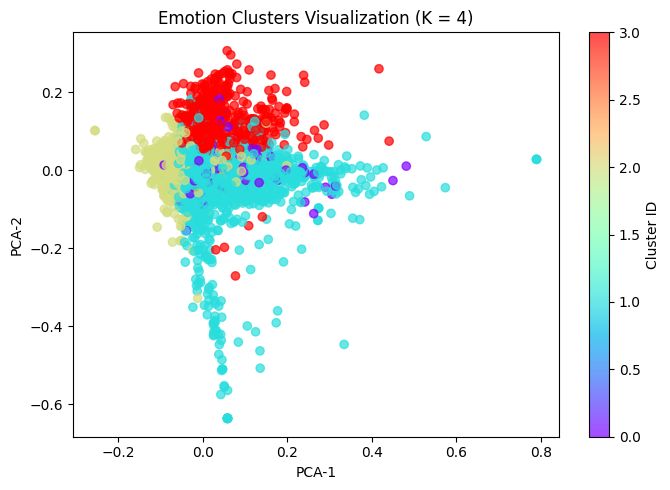

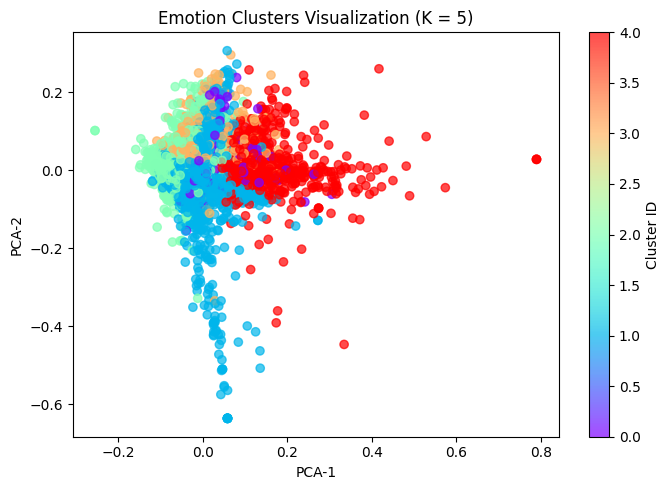

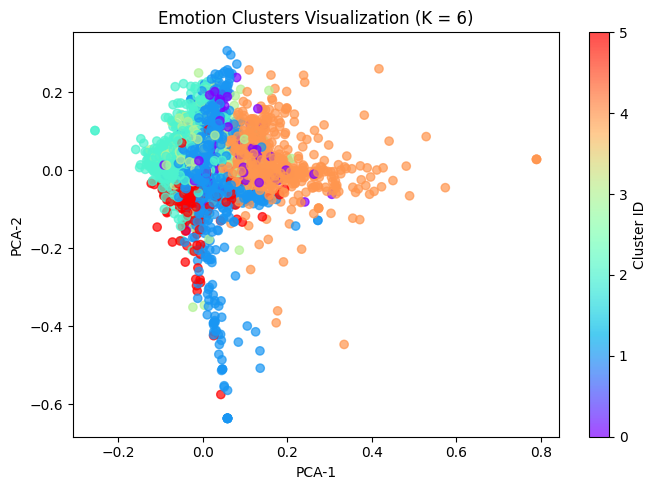

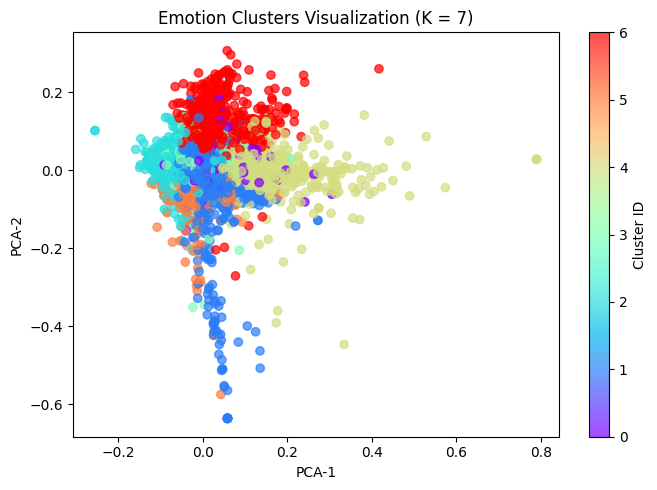

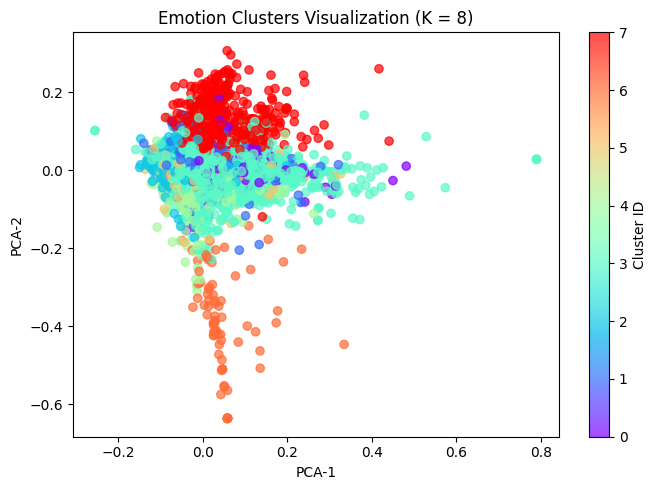

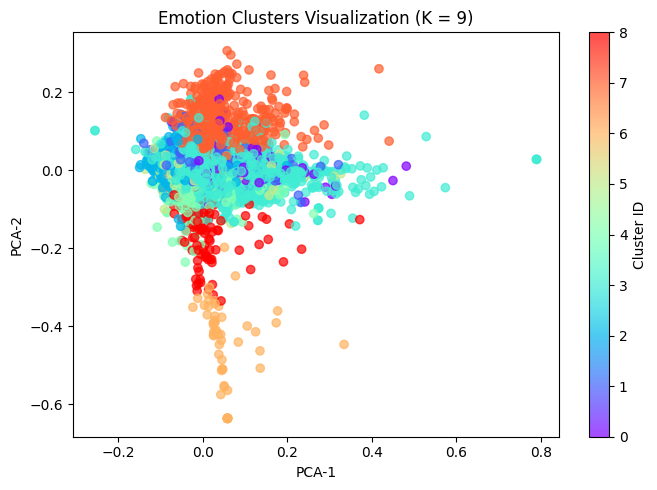

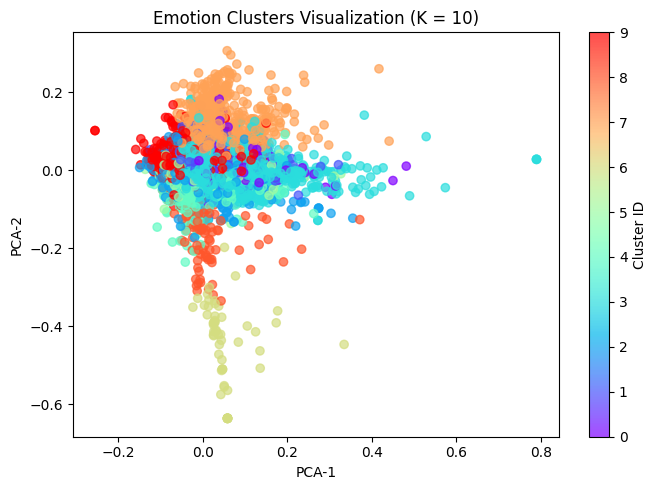

In [ ]:
for k in range(2, 11):
  plot_clusters_pca(data_tfidf_pca, labels, k)


#Cụm nhãn thật

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = data['Emotion']
le = LabelEncoder()
y = le.fit_transform(y)

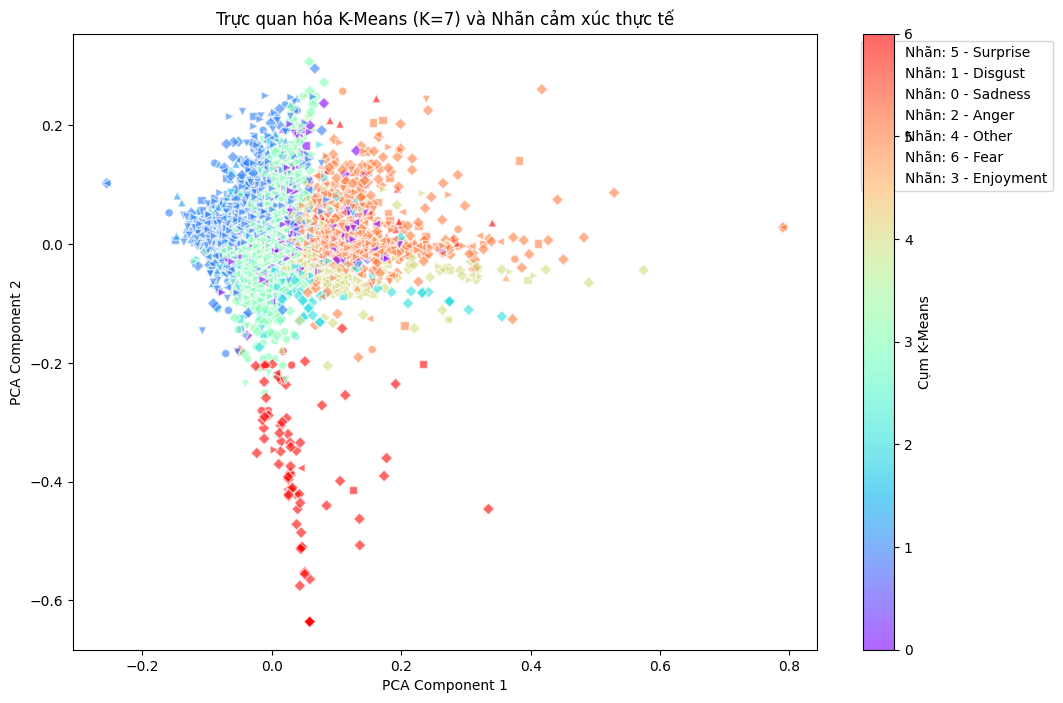

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Giảm chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_tfidf_pca) # X là ma trận đặc trưng (TF-IDF/Word2Vec)

# 2. Cài đặt số lượng cụm K=7
k_best = 7
labels_kmeans = pd.Series(labels[5]) # Nhãn từ thuật toán
labels_true = pd.Series(y) # Nhãn cảm xúc thực tế

# 3. Trực quan hóa
plt.figure(figsize=(12, 8))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p'] # Danh sách hình dạng cho nhãn gốc

for i, label in enumerate(labels_true.unique()):
    mask = (labels_true == label)
    # Vẽ từng nhãn gốc với hình dạng riêng, màu sắc theo cụm KMeans
    plt.scatter(data_tfidf_pca[mask, 0], data_tfidf_pca[mask, 1],
                c=labels_kmeans[mask],
                marker=markers[i % len(markers)],
                label=f'Nhãn: {label} - {unique_labels_true[label]}',
                cmap='rainbow', alpha=0.6, edgecolors='w')

plt.title(f"Trực quan hóa K-Means (K={k_best}) và Nhãn cảm xúc thực tế")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.colorbar(label='Cụm K-Means')
plt.show()